In [665]:
import os
from pathlib import Path
import numpy as np
import sys
import pandas as pd
from tqdm import tqdm


Street Cleanliness

In [739]:
data_path = Path('data')
street_df = pd.read_csv(data_path / 'Scorecard/Scorecard_Ratings.csv')

In [740]:
group_by = street_df.groupby('Borough')
street_df['Borough'] = street_df['Borough'].str.lower()
print (street_df['Borough'].unique())

['brooklyn' 'staten island' 'bronx' 'manhattan' 'queens']


In [741]:
street_df.columns

Index(['Month', 'Borough', 'Community Board', 'District', 'Cleaning Section',
       'Acceptable Streets %', 'Acceptable Sidewalks %',
       'Acceptable Streets % - Previous Month',
       'Acceptable Sidewalks % - Previous Month',
       'Acceptable Streets % - Previous Year',
       'Acceptable Sidewalks % - Previous Year',
       'Acceptable Streets % - Previous Fiscal Quarter',
       'Acceptable Sidewalks % - Previous Fiscal Quarter'],
      dtype='object')

In [742]:
idx = street_df['Month'].str.startswith('2016') | street_df['Month'].str.startswith('2015')
street_df = street_df[idx]
street_df['Month'] = pd.to_datetime(street_df['Month'])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [743]:
street_df.columns
street_df = street_df.drop(columns=['District','Cleaning Section','Community Board'])

In [744]:
def merge_by_month(df, borough_name):
    date_range = pd.to_datetime(pd.date_range('2014-12-30','2017-01-01',freq='1M'))
    # print (date_range)
    res = pd.DataFrame()
    for idx in tqdm(range(1,len(date_range))):
        selected_month = (df['Month']>=date_range[idx-1]) & (df['Month'] < date_range[idx])
        df_selected = df[selected_month]
        df_selected = df_selected.mean(axis=0)
        # df_selected['month']= pd.to_datetime(date_range[idx-1])
        res = res.append(df_selected,ignore_index=True)
    res.insert(0,'month',date_range[:-1])
    res.insert(0,'borough',borough_name)
    return res

In [745]:
street_gp = street_df.groupby('Borough')
borough_list = []
# result_grouped.groups.keys()
for i in result_grp.groups.keys():
    grp = street_gp.get_group(i)
    borough_list.append(merge_by_month(grp, i))

100%|██████████| 24/24 [00:00<00:00, 190.84it/s]


In [746]:
final_street_df = pd.concat(borough_list).reset_index(drop=True)


In [747]:
final_street_df.loc[0,['month','borough']]

month      2014-12-31 00:00:00
borough                  bronx
Name: 0, dtype: object

In [748]:
for i in range(1,final_street_df.shape[0]):
    nan_columns = final_street_df.columns[final_street_df.iloc[i].isna()]
    if nan_columns.size != 0:
        final_street_df.loc[i,nan_columns] = final_street_df.loc[i-1,nan_columns]

Air Quality

In [749]:
# combine 2015 and 2016 data
_air_dict = {}
for i in ['kings', 'queens', 'manhattan', 'staten island', 'bronx']:
    air_df_2016 = pd.read_csv('data/Air Quality/nyc air '+ i +' 2016.csv')
    air_df_2015 = pd.read_csv('data/Air Quality/nyc air '+ i +' 2015.csv')
    _air_dict[i] = pd.concat([air_df_2015, air_df_2016])

In [750]:
def get_feature_by_month(df,borough_name):
    df = df.rename(columns={'Date':'month','PM25':'PM2.5'})
    date_range = pd.to_datetime(pd.date_range('2014-12-30','2017-01-01',freq='1M'))
    df['month'] = pd.to_datetime(df['month'])
    res = pd.DataFrame()
    item = {}
    for idx in tqdm(range(1,len(date_range))):
        selected_month = (df['month']>=date_range[idx-1]) & (df['month'] < date_range[idx])
        df_selected = df[selected_month]
        item['month'] = date_range[idx - 1]
        item['Overall AQI Value'] = df_selected['Overall AQI Value'].mean(axis=0)
        total = len(df_selected)
        for i in ['CO', 'PM2.5','SO2','NO2','Ozone']:
            item[i] = (df_selected['Main Pollutant'] == i).sum()/  total
        item['borough'] = borough_name
        res = res.append(item,ignore_index=True)
    
    return res

In [751]:
for i in ['kings', 'queens', 'manhattan', 'staten island', 'bronx']:
    _air_dict[i] = get_feature_by_month(_air_dict[i],i)

100%|██████████| 24/24 [00:00<00:00, 169.56it/s]


In [752]:
final_air = pd.concat((_air_dict.values()))
final_air = final_air.reset_index(drop=True)
final_air.head(2)

,CO,NO2,Overall AQI Value,Ozone,PM2.5,SO2,borough,month
0,0.0,0.0,44.466667,0.0,1.0,0.0,kings,2014-12-31
1,0.0,0.0,44.535714,0.0,1.0,0.0,kings,2015-01-31


Crime Rate

In [722]:
crime_df = pd.read_csv(data_path / 'Crime Rate/crime 2015-2016.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [723]:

# print (crime_df.columns)

crime_df['BORO_NM'] = crime_df['BORO_NM'].str.lower()
crime_df['VIC_RACE']
crime_df.head(5)

,Unnamed: 0,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,3018410,111222720,06/11/2015,11:36:00,NaN,NaN,44.0,06/11/2015,341,PETIT LARCENY,...,M,NaN,40.830128,-73.914423,"(40.830128476, -73.914422779)",PATROL BORO BRONX,NaN,45-64,BLACK,M
1,3018411,292167760,09/03/2015,17:10:00,NaN,NaN,44.0,09/03/2015,235,DANGEROUS DRUGS,...,M,NaN,40.833925,-73.927008,"(40.833924833, -73.927008074)",PATROL BORO BRONX,NaN,NaN,UNKNOWN,E
2,3018420,594527773,04/01/2016,00:01:00,04/30/2018,23:59:00,34.0,05/29/2018,104,RAPE,...,M,NaN,40.851488,-73.935458,"(40.851487774, -73.935457967)",PATROL BORO MAN NORTH,NaN,<18,WHITE HISPANIC,F
3,3018424,487791415,04/27/2015,16:00:00,NaN,NaN,113.0,04/27/2015,126,MISCELLANEOUS PENAL LAW,...,M,NaN,40.681686,-73.771141,"(40.681686211, -73.77114086)",PATROL BORO QUEENS SOUTH,NaN,25-44,BLACK,F
4,3018434,926821201,02/21/2016,20:10:00,NaN,NaN,32.0,02/21/2016,106,FELONY ASSAULT,...,U,NaN,40.809413,-73.944367,"(40.809413199, -73.944367164)",PATROL BORO MAN NORTH,NaN,<18,BLACK,M


In [724]:
crime_df['RPT_DT'].unique()

array(['06/11/2015', '09/03/2015', '05/29/2018', ..., '11/18/2017',
       '08/19/2017', '11/23/2017'], dtype=object)

In [725]:
crime_df['BORO_NM'].unique()

array(['bronx', 'manhattan', 'queens', 'brooklyn', 'staten island', nan],
      dtype=object)

In [726]:
whitelist = {'BORO_NM','CMPLNT_FR_DT','CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM','CRM_ATPT_CPTD_CD','OFNS_DESC'
            ,'KY_CD','SUSP_AGE_GROUP','SUSP_SEX','VIC_RACE','VIC_SEX','VIC_AGE_GROUP'}

In [727]:
crime_new = crime_df.copy()
for i in crime_df.columns:
    if i not in whitelist:
        crime_new = crime_new.drop(columns=i)

In [728]:
crime_new.head(5)

,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,KY_CD,OFNS_DESC,CRM_ATPT_CPTD_CD,BORO_NM,SUSP_AGE_GROUP,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,06/11/2015,11:36:00,NaN,NaN,341,PETIT LARCENY,COMPLETED,bronx,NaN,M,45-64,BLACK,M
1,09/03/2015,17:10:00,NaN,NaN,235,DANGEROUS DRUGS,COMPLETED,bronx,18-24,M,NaN,UNKNOWN,E
2,04/01/2016,00:01:00,04/30/2018,23:59:00,104,RAPE,COMPLETED,manhattan,UNKNOWN,M,<18,WHITE HISPANIC,F
3,04/27/2015,16:00:00,NaN,NaN,126,MISCELLANEOUS PENAL LAW,COMPLETED,queens,25-44,M,25-44,BLACK,F
4,02/21/2016,20:10:00,NaN,NaN,106,FELONY ASSAULT,COMPLETED,manhattan,UNKNOWN,U,<18,BLACK,M


In [729]:
crime_new['SUSP_AGE_GROUP'].unique()
# print ((crime_new['SUSP_AGE_GROUP'].isna()).sum())
susp_age_known = ~crime_new['SUSP_AGE_GROUP'].isin(['<18','25-44','18-24','45-64','65+','UNKNOWN'])
result = crime_new.drop(crime_new.loc[susp_age_known].index)
vic_age_known = ~result['VIC_AGE_GROUP'].isin(['<18','25-44','18-24','45-64','65+','UNKNOWN'])
result = crime_new.drop(result.loc[vic_age_known].index)
print (len(result))

903656


In [730]:
result['SUSP_AGE_GROUP'].unique()
result['CMPLNT_FR_DT'] = pd.to_datetime(result['CMPLNT_FR_DT'])
result['CMPLNT_FR_TM'] = pd.to_timedelta(result['CMPLNT_FR_TM'])

In [731]:
import datetime
pd.date_range('2015-12-31','2017-01-01',freq='1M')

DatetimeIndex(['2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31'],
              dtype='datetime64[ns]', freq='M')

In [732]:
def avg_datetime(series):
    import functools
    import operator
    dt_min = series.min()
    deltas = [x-dt_min for x in series]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

In [733]:
def merge_features(df,felonies, vic_race,age_group,drop_columns=False):
    date_range = pd.to_datetime(pd.date_range('2014-12-30','2017-01-01',freq='1M'))
    res = pd.DataFrame()
    for idx in tqdm(range(1,len(date_range))):
        item = {}
        selected_month = (df['CMPLNT_FR_DT']>=date_range[idx-1]) & (df['CMPLNT_FR_DT'] < date_range[idx])
        df_selected = df[selected_month]
        item['COMPLETION'] = (df_selected['CRM_ATPT_CPTD_CD'] == 'COMPLETED').sum()
        for i in age_group:
            item['susp_age '+ i] = (df_selected['SUSP_AGE_GROUP'] == i).sum()
        for j in vic_race:
            item['vic_race_' + j] = (df_selected['VIC_RACE'] == j ).sum()

        for k in felonies:
            item[k] = (df_selected['OFNS_DESC'] == k).sum()
        item['vic_female'] = (df_selected['VIC_SEX'] == 'F').sum()
        item['vic_male'] = (df_selected['VIC_SEX'] == 'M').sum()
        item['vic_organ'] = (df_selected['VIC_SEX'] == 'D').sum()
        item['total_num'] = len(df_selected)
        item['cmplt_time_mean'] = avg_datetime(df_selected['CMPLNT_FR_TM'])
        item['borough'] = df_selected['BORO_NM'].iloc[0]
        item['period'] = date_range[idx-1]
        res = res.append(item,ignore_index=True)
    return res
    

In [734]:
# print (crime_df['OFNS_DESC'].unique())
# print (crime_df['VIC_RACE'].unique())
# print (crime_df['CRM_ATPT_CPTD_CD'].unique())

In [735]:
months = 12
age_group = ['<18','25-44','18-24','45-64','65+','UNKNOWN']
vic_race = crime_df['VIC_RACE'].unique()[:-1]

felonies = ['RAPE','SEX CRIMES','ROBBERY','BURGLARY','CRIMINAL TRESPASS',
            'KIDNAPPING & RELATED OFFENSES','PROSTITUTION & RELATED OFFENSES',
             'HARRASSMENT 2','DANGEROUS DRUGS']
result_grp = result.groupby('BORO_NM')
borough_df_list = []
# result_grouped.groups.keys()
for i in result_grp.groups.keys():
    grp = result_grp.get_group(i)
    borough_df_list.append(merge_features(grp,felonies=felonies,age_group=age_group,
                                          vic_race=vic_race,drop_columns=True))
    

100%|██████████| 24/24 [00:01<00:00, 14.39it/s]


In [736]:
# borough_df_list[0]
final_crime_df = pd.concat(borough_df_list).reset_index(drop=True)

In [737]:
# final_df.to_csv('/Users/apple/Desktop/crime_reduced.csv')

In [738]:
final_crime_df['borough'].unique()
print (final_crime_df.shape)

(120, 30)


##### Merging all the 3 datasets

In [754]:
final_crime_df = final_crime_df.rename(columns={'period':'month'})
print (final_street_df.columns)
print (final_air.columns)
print (final_crime_df.columns)
print (set(final_street_df.columns).intersection(set(final_air.columns)).intersection(set(final_crime_df.columns)))

Index(['borough', 'month', 'Acceptable Sidewalks %',
       'Acceptable Sidewalks % - Previous Fiscal Quarter',
       'Acceptable Sidewalks % - Previous Month',
       'Acceptable Sidewalks % - Previous Year', 'Acceptable Streets %',
       'Acceptable Streets % - Previous Fiscal Quarter',
       'Acceptable Streets % - Previous Month',
       'Acceptable Streets % - Previous Year'],
      dtype='object')
Index(['CO', 'NO2', 'Overall AQI Value', 'Ozone', 'PM2.5', 'SO2', 'borough',
       'month'],
      dtype='object')
Index(['BURGLARY', 'COMPLETION', 'CRIMINAL TRESPASS', 'DANGEROUS DRUGS',
       'HARRASSMENT 2', 'KIDNAPPING & RELATED OFFENSES',
       'PROSTITUTION & RELATED OFFENSES', 'RAPE', 'ROBBERY', 'SEX CRIMES',
       'borough', 'cmplt_time_mean', 'month', 'susp_age 18-24',
       'susp_age 25-44', 'susp_age 45-64', 'susp_age 65+', 'susp_age <18',
       'susp_age UNKNOWN', 'total_num', 'vic_female', 'vic_male', 'vic_organ',
       'vic_race_AMERICAN INDIAN/ALASKAN NATIVE',
 

In [755]:
final_air.head(2)

,CO,NO2,Overall AQI Value,Ozone,PM2.5,SO2,borough,month
0,0.0,0.0,44.466667,0.0,1.0,0.0,kings,2014-12-31
1,0.0,0.0,44.535714,0.0,1.0,0.0,kings,2015-01-31


In [797]:
air_crime_merged = pd.merge(final_crime_df,final_air,how='left',left_on=['month','borough'],right_on=['month','borough'])
final_dataset = pd.merge(air_crime_merged, final_street_df,how='left',left_on=['month','borough'],right_on=['month','borough'])

In [798]:
print (final_dataset.shape)
final_dataset['month'].unique()

(120, 44)


array(['2014-12-31T00:00:00.000000000', '2015-01-31T00:00:00.000000000',
       '2015-02-28T00:00:00.000000000', '2015-03-31T00:00:00.000000000',
       '2015-04-30T00:00:00.000000000', '2015-05-31T00:00:00.000000000',
       '2015-06-30T00:00:00.000000000', '2015-07-31T00:00:00.000000000',
       '2015-08-31T00:00:00.000000000', '2015-09-30T00:00:00.000000000',
       '2015-10-31T00:00:00.000000000', '2015-11-30T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-01-31T00:00:00.000000000',
       '2016-02-29T00:00:00.000000000', '2016-03-31T00:00:00.000000000',
       '2016-04-30T00:00:00.000000000', '2016-05-31T00:00:00.000000000',
       '2016-06-30T00:00:00.000000000', '2016-07-31T00:00:00.000000000',
       '2016-08-31T00:00:00.000000000', '2016-09-30T00:00:00.000000000',
       '2016-10-31T00:00:00.000000000', '2016-11-30T00:00:00.000000000'],
      dtype='datetime64[ns]')

Approaches

#### Approach \#1: using Gaussian Mixture Models

In [1039]:
# final_dataset = pd.read_excel('data/final_dataset.xlsx')

In [1040]:
final_dataset_edited = final_dataset.drop(columns=['cmplt_time_mean'])
print (final_dataset_edited.columns)

Index(['BURGLARY', 'COMPLETION', 'CRIMINAL TRESPASS', 'DANGEROUS DRUGS',
       'HARRASSMENT 2', 'KIDNAPPING & RELATED OFFENSES',
       'PROSTITUTION & RELATED OFFENSES', 'RAPE', 'ROBBERY', 'SEX CRIMES',
       'borough', 'month', 'susp_age 18-24', 'susp_age 25-44',
       'susp_age 45-64', 'susp_age 65+', 'susp_age <18', 'susp_age UNKNOWN',
       'total_num', 'vic_female', 'vic_male', 'vic_organ',
       'vic_race_AMERICAN INDIAN/ALASKAN NATIVE',
       'vic_race_ASIAN / PACIFIC ISLANDER', 'vic_race_BLACK',
       'vic_race_BLACK HISPANIC', 'vic_race_UNKNOWN', 'vic_race_WHITE',
       'vic_race_WHITE HISPANIC', 'CO', 'NO2', 'Overall AQI Value', 'Ozone',
       'PM2.5', 'SO2', 'Acceptable Sidewalks %',
       'Acceptable Sidewalks % - Previous Fiscal Quarter',
       'Acceptable Sidewalks % - Previous Month',
       'Acceptable Sidewalks % - Previous Year', 'Acceptable Streets %',
       'Acceptable Streets % - Previous Fiscal Quarter',
       'Acceptable Streets % - Previous Month',

In [1043]:
from sklearn import mixture
from time import time
X = final_dataset_edited.drop(columns=['month'])
from sklearn import preprocessing

n_components = 7
# print (X.columns)
for i in range(X.shape[0]):
    nan_columns = X.columns[X.iloc[i].isna()]
    if len(nan_columns) != 0:
        X.loc[i,nan_columns] = X.loc[i-1,nan_columns]
X = X.sample(frac=1)
print (X.shape)
X_train, X_test = X.loc[:110,:], X.loc[110:,:]

X_train,X_test = X_train.drop(columns=['borough']) , X_test.drop(columns=['borough']) 
X_norm = preprocessing.MinMaxScaler().fit_transform(X_train)


print (X_norm.shape)
gmm = mixture.BayesianGaussianMixture(n_components=n_components, covariance_type='full').fit(X_norm)

(120, 42)
(111, 41)


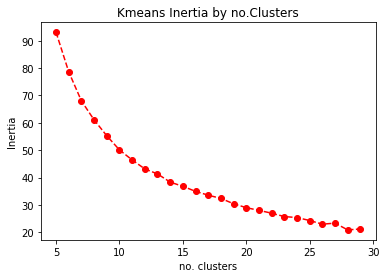

In [1174]:
from sklearn.cluster import KMeans
n_clusters = 0
inertia = []
for i in range(5,30):
    n_clusters = i
    kmeans = KMeans(n_clusters= n_clusters)
    kmeans_pred = kmeans.fit_predict(X_norm)
    inertia.append(kmeans.inertia_)
    
from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.ylabel('Inertia')
plt.xlabel('no. clusters')
plt.title('Kmeans Inertia by no.Clusters')
plt.plot(range(5,30), inertia, 'ro--')
# cluster_groups = K.fit_predict(X_norm)
plt.show()


In [1175]:
fig.savefig('img/kmeans.png', bbox_inches='tight')

In [1045]:
kmeans = KMeans(n_clusters= 7)
clusters_kmeans = kmeans.fit_predict(X_norm)
print (clusters_kmeans)

[5 5 0 0 2 4 2 3 1 4 6 3 2 6 3 6 3 0 4 3 1 4 3 2 4 3 3 3 6 6 4 1 6 6 2 0 1
 4 1 3 6 6 1 0 6 6 0 4 3 2 1 0 3 5 2 1 1 2 5 6 3 1 1 4 3 3 5 0 3 5 2 3 5 0
 6 2 6 1 4 2 0 4 6 1 3 0 4 5 1 5 2 4 6 0 3 6 2 6 1 1 3 6 0 1 4 2 6 6 6 1 3]


In [1046]:

cluster_groups = gmm.fit_predict(X_norm)
print (cluster_groups)

[5 5 2 2 4 4 4 3 1 4 0 3 4 0 3 0 3 2 4 3 1 4 3 4 4 3 3 3 1 0 4 6 1 1 4 2 6
 4 1 3 0 0 1 2 0 1 2 6 3 4 1 2 3 5 4 1 1 4 5 1 3 6 1 4 3 3 5 2 3 5 4 3 5 2
 0 4 0 6 6 4 2 4 0 1 3 2 4 5 6 5 4 4 0 2 3 0 4 0 1 6 3 0 2 6 4 4 0 1 0 1 3]


In [1182]:
centers = gmm.means_
cov = gmm.covariances_

(41, 41)
(41, 41)
(41, 41)
(41, 41)
(41, 41)
(41, 41)
(41, 41)


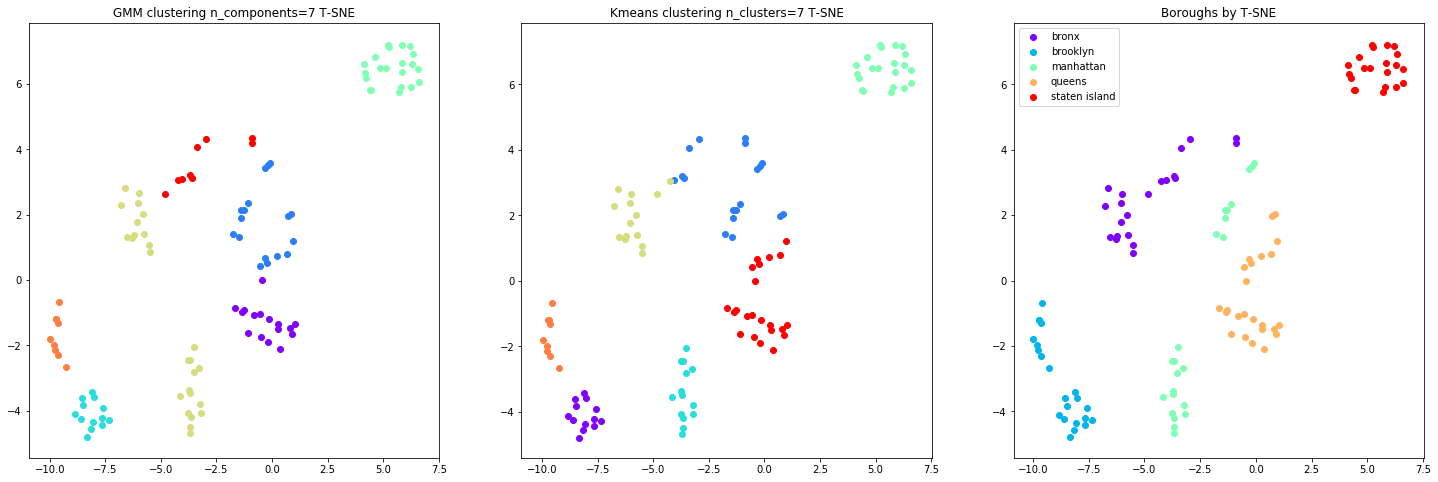

In [1185]:
from sklearn import manifold, datasets
from matplotlib import pyplot as plt
from sklearn import preprocessing
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
from scipy.linalg import eigh
tsne = manifold.TSNE(n_components=2, init='random', perplexity=30)

X_transformed = tsne.fit_transform(X_norm)

fig , subplots = plt.subplots(1,3,figsize=(25,8))
ax = subplots[0]

colors = cm.rainbow(np.linspace(0, 1, n_components))
for i in range(n_components):
    v, w = eigh(cov[i])
    print (w.shape)
    idx = cluster_groups == i
    ax.scatter(X_transformed[idx,0],X_transformed[idx,1],color=colors[i])
ax.axis('tight')
_ = ax.set_title(f'GMM clustering n_components={n_components} T-SNE')

ax = subplots[2]

colors = cm.rainbow(np.linspace(0, 1, 5))
for idx,i in enumerate(final_dataset_edited['borough'].unique()):
    ind = X.loc[:110,'borough'] == i
    ax.scatter(X_transformed[ind,0],X_transformed[ind,1],color=colors[idx],label=i)
ax.axis('tight')
_ = ax.set_title('Boroughs by T-SNE')
ax.legend()

ax = subplots[1]

colors = cm.rainbow(np.linspace(0, 1, 7))
for i in range(7):
    idx = clusters_kmeans == i
    ax.scatter(X_transformed[idx,0],X_transformed[idx,1],color=colors[i])
ax.axis('tight')
_ = ax.set_title(f'Kmeans clustering n_clusters={7} T-SNE')
# plt.show()


In [1173]:
fig.savefig('img/clustering.png')

In [1053]:
print (centers_df.columns)

Index(['BURGLARY', 'COMPLETION', 'CRIMINAL TRESPASS', 'DANGEROUS DRUGS',
       'HARRASSMENT 2', 'KIDNAPPING & RELATED OFFENSES',
       'PROSTITUTION & RELATED OFFENSES', 'RAPE', 'ROBBERY', 'SEX CRIMES',
       'susp_age 18-24', 'susp_age 25-44', 'susp_age 45-64', 'susp_age 65+',
       'susp_age <18', 'susp_age UNKNOWN', 'total_num', 'vic_female',
       'vic_male', 'vic_organ', 'vic_race_AMERICAN INDIAN/ALASKAN NATIVE',
       'vic_race_ASIAN / PACIFIC ISLANDER', 'vic_race_BLACK',
       'vic_race_BLACK HISPANIC', 'vic_race_UNKNOWN', 'vic_race_WHITE',
       'vic_race_WHITE HISPANIC', 'CO', 'NO2', 'Overall AQI Value', 'Ozone',
       'PM2.5', 'SO2', 'Acceptable Sidewalks %',
       'Acceptable Sidewalks % - Previous Fiscal Quarter',
       'Acceptable Sidewalks % - Previous Month',
       'Acceptable Sidewalks % - Previous Year', 'Acceptable Streets %',
       'Acceptable Streets % - Previous Fiscal Quarter',
       'Acceptable Streets % - Previous Month',
       'Acceptable Streets

In [1054]:
def score_metric(x,weights=None,pos_features=None):
    x_cp = x.copy()
    for i in x_cp.columns:
        if i not in pos_features:
            x_cp[i] = 1 - x_cp[i]
    if weights == None:
        return x_cp.sum(axis=1) / x_cp.shape[1]
    else:
        score = 0
        for key,w in weights.items():
            score += w * x_cp[key]
        return score / sum(w.values)

In [1055]:
center_scores = score_metric(centers_df,pos_features=['Acceptable Streets %',
       'Acceptable Sidewalks %', 'Acceptable Streets % - Previous Month',
       'Acceptable Sidewalks % - Previous Month',
       'Acceptable Streets % - Previous Year',
       'Acceptable Sidewalks % - Previous Year',
       'Acceptable Streets % - Previous Fiscal Quarter',
       'Acceptable Sidewalks % - Previous Fiscal Quarter'])

Scoring training data points based on distance

In [1056]:
from scipy.spatial.distance import mahalanobis, cosine, euclidean
from numpy.linalg import norm

In [1057]:
# function to compare if a data point is better or worse compared to center
def cmp_to_center(center,data_point,weights=None,pos_features=None):
    r = data_point
    r[:,pos_features] = 1 - r[:,pos_features]
    center[:,pos_features] = 1 - center[:,pos_features]
    if weights != None:
        return (weights * (r - center)).sum()
    else:
        return (r - center).sum()

In [1058]:
# data point distance from center based on l1-norm, mahalanobis, euclidean and cosine distance.
mahal_dist = np.zeros((X_train.shape[0]),dtype=np.float32)
cosine_dist = mahal_dist.copy()
norm1_dist = mahal_dist.copy()
euc_dist = mahal_dist.copy()
datapoint_sign = np.zeros((X_train.shape[0]),dtype=np.float32)
for j in range(X_train.shape[0]):
    # print (centers)
    cluster = cluster_groups[j]
    grp = X_norm[ cluster == cluster_groups]
    mahal_dist[j] = mahalanobis(X_norm[j:j+1,:],centers[cluster_groups[j],:], np.linalg.pinv(np.cov(grp.T))) / 41
    cosine_dist[j] = cosine(X_norm[j:j+1,:],centers[cluster_groups[j],:])
    norm1_dist[j] = norm(X_norm[j:j+1,:] - centers[cluster_groups[j],:],ord=1) /41
    euc_dist[j] = euclidean(X_norm[j:j+1,:], centers[cluster_groups[j],:]) / 41
    datapoint_sign[j] = cmp_to_center(X_norm[j:j+1,:], centers[cluster_groups[j],:]) / 41

In [1059]:
datapoint_sign[datapoint_sign >= 0] = 1
datapoint_sign[datapoint_sign <= 0] = -1

In [1161]:
cluster_main_score = center_scores[cluster_groups]
X_train_score = cluster_main_score + (datapoint_sign * norm1_dist)

Now using SVM for regression

In [1162]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
clf_rbf = SVR(C=1.0,gamma='scale',kernel='rbf')
_ = clf_rbf.fit(X_norm,X_train_score)
svm_prediction = clf_rbf.predict(X_norm)
mean_squared_error(X_train_score,svm_prediction)

0.007005995872387788

In [1163]:

clf_linear = SVR(C=0.1,gamma='scale',kernel='linear')
_ = clf_linear.fit(X_norm,X_train_score)

svm_prediction = clf_linear.predict(X_norm)
mean_squared_error(X_train_score,svm_prediction)

0.01617736429382465

In [1164]:
from sklearn.neighbors import KNeighborsRegressor as KNR

In [1165]:
knr = KNR(n_neighbors=5,p=2).fit(X_norm, X_train_score)
knr_pred = knr.predict(X_norm)
mean_squared_error(X_train_score, knr_pred)

0.0029061380432423953

In [1070]:
X_test_norm = preprocessing.MinMaxScaler().fit_transform(X_test)
test_prediction =gmm.predict(X_test_norm)
print (test_prediction)

[4 4 4 4 4 4 4 4 4 4]


In [1071]:
clf_rbf.predict(X_test_norm.reshape(-1,41))

array([0.58739197, 0.67864593, 0.48589249, 0.53447136, 0.57026225,
       0.60727188, 0.60004349, 0.59756213, 0.58039376, 0.63375101])